In [4]:
import numpy as np
import cvxpy as cp

# 1.
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
# my device values inserted here
CpH =  8.237             # heat capacity of the heater (J/deg C)
CpS = 1.636              # heat capacity of the sensor (J/deg C)
Ua =  0.0408             # heat transfer coefficient from heater to environment
Ub = 0.0953              # heat transfer coefficient from heater to sensor
Uc = 0.0294              # heat transfer coefficient from heater to sensor
Tamb = 22              # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

In [3]:
# 3. Write an optimization model to find the greatest temperature differential between  𝑇1  and  𝑇2  
# while limiting both to temperatures less than 60 deg C. Verify this prediction using your hardware.

# knowns
d = d_initial            # disturbance

# unknowns to be computed
u = cp.Variable(2)
x = cp.Variable(4)
y = cp.Variable(2)

# objective
objective = cp.Maximize(y[1]-y[0])

# model constraints
model_constraints = [
    0 == A@x + Bu@u + Bd@d,
    y == C@x]

# input constraints
input_constraints = [0 <= u, u <= 100]


# output constraints
output_constraints = [0 <= x, x <= 60]


# solve problem
constraints = model_constraints + input_constraints + output_constraints
problem = cp.Problem(objective, constraints)
problem.solve()

# display solution
print(f"u = {u.value}")
print(f"x = {x.value}")
print(f"y = {y.value}")

U1_ = u.value[0]
U2_ = u.value[1]
print(U1_,U2_)

u = [3.67437352e-10 1.00000000e+02]
x = [33.57571462 33.57571462 49.63997165 49.63997165]
y = [33.57571462 49.63997165]
3.674373516222105e-10 99.9999999981556


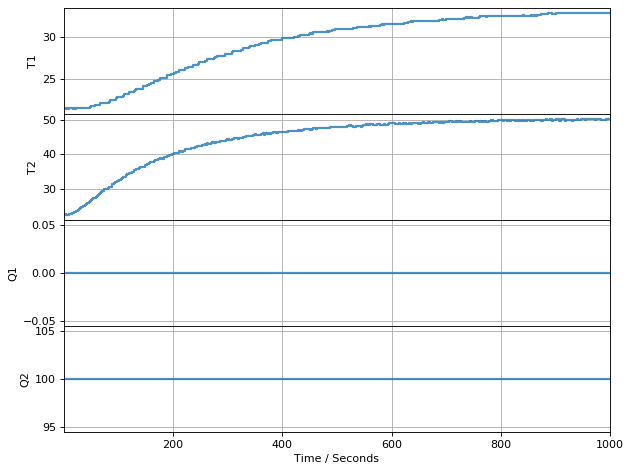

TCLab disconnected successfully.


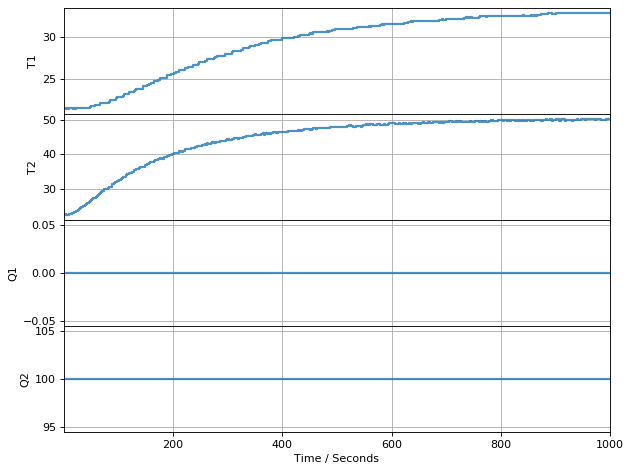

In [2]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# Set the parameters
t_final = 1000
t_step = 2

# Create the event loop
TCLab = setup(connected=True)
with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final, t_step):
        T1 = lab.T1
        T2 = lab.T2
        lab.Q1(U1_)
        lab.Q2(U2_)
        p.update(t) 

As seen from the graph above, the optimization model successfully found the heater values, U1 and U2, that gave the greatest temperature differential between T1 and T2. When these heater values were implemented in an experiment with my device, the temperatures reached the predicted steady-state values that gave a maximum difference between the two - T1 was predicted as approximately 33.5 deg. C. and during the experiment reached to approximately 34 deg. C while T2 was predicted as approximately 50 deg. C. and this value was reached during the experiment.